# DC resistivity forward modelling to determine detectability of fault offset: A case study of two sites in the Fraser Canyon: Phase 1
_Raul Benjamin Mendoza_

In this notebook, I aim to use _discretize_ and _SimPEG_ to replicate the results I attained from inverting field data using EarthImager:
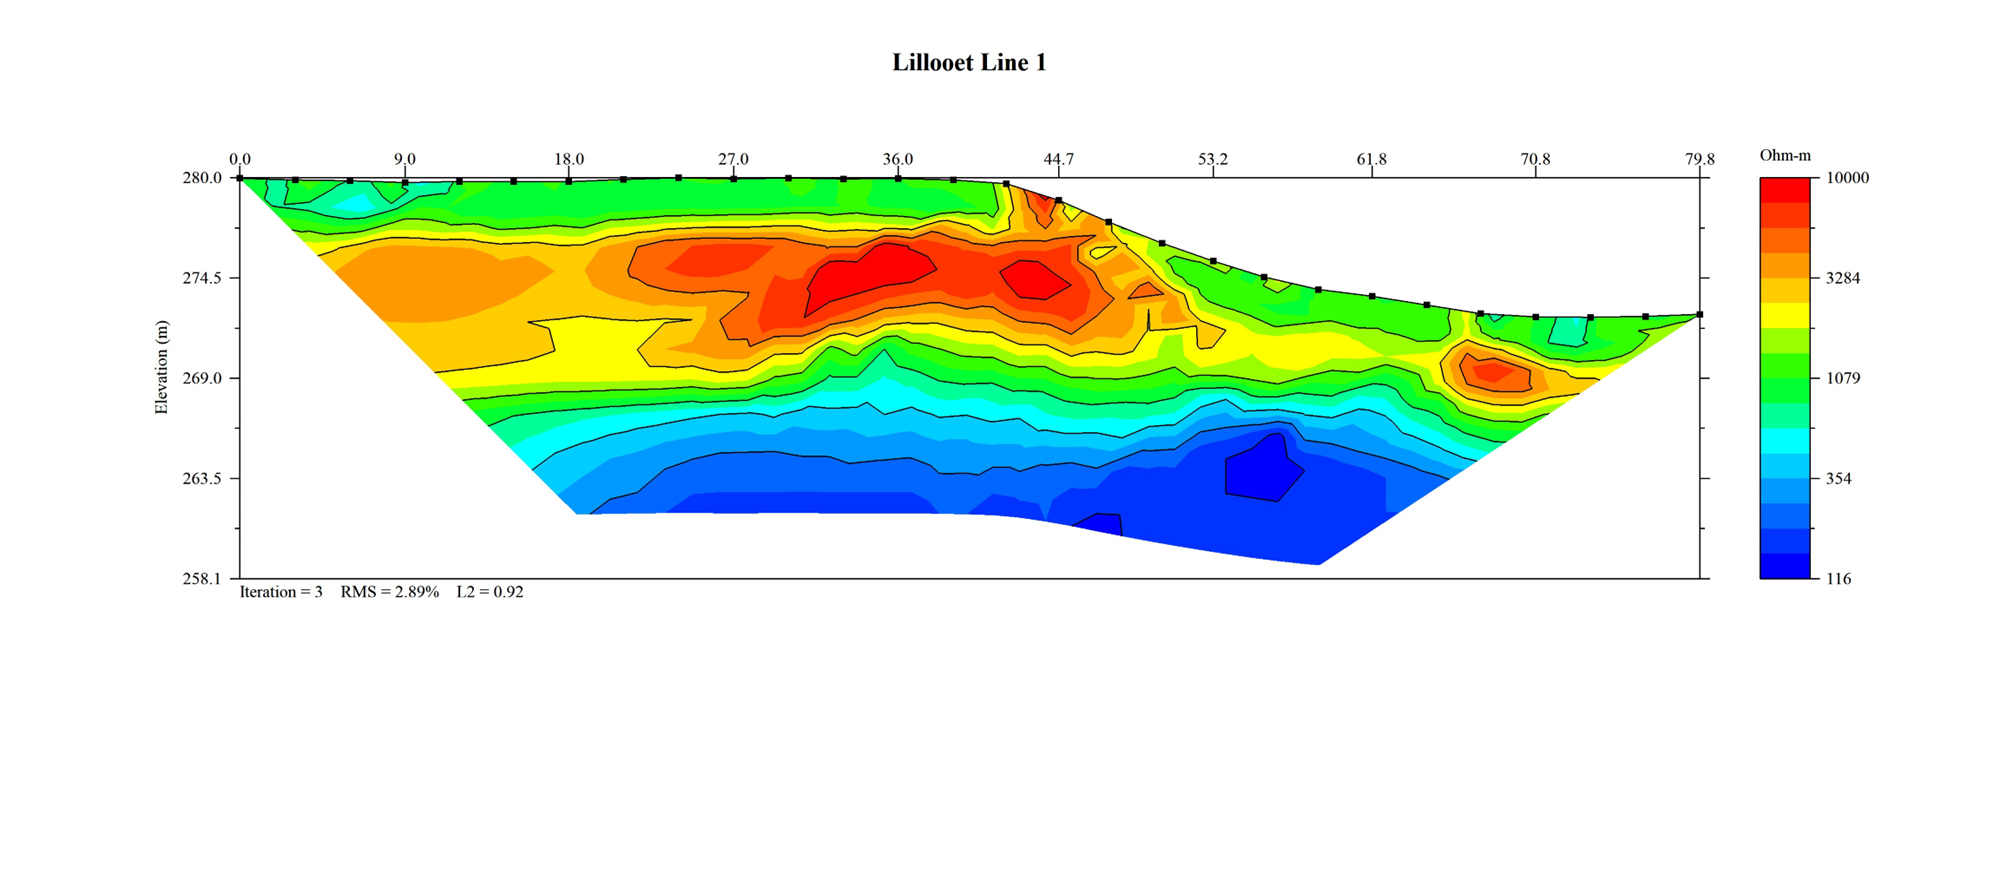

For now, this notebook loosely follows the SimPEG 2.5D DC Resistivity forward modelling and inversion tutorial notebooks (https://simpeg.xyz/user-tutorials/fwd-dcr-2d & https://simpeg.xyz/user-tutorials/inv-dcr-2d). 

## Import packages for forward modelling

In [ ]:
# SimPEG functionality
import simpeg
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.utils import model_builder
from simpeg import maps, data
from simpeg.electromagnetics.static.utils.static_utils import (
    write_dcip2d_ubc,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
    generate_survey_from_abmn_locations,
    geometric_factor
)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz

# Common Python functionality
import os
import numpy as np
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

# Functions specific to this project
from project_functions import (
    create_topography_from_terrain_file,
    plot_topography_from_dataframe,
    extract_survey_and_data_from_stg,
    plot_survey,
    create_mesh_from_survey,
    plot_mesh_and_survey,
    plot_model_on_survey_and_mesh,
    plot_normalized_volts_and_apparent_resistivity,
    create_data_object,
    save_model_to_txt,
    load_model_from_txt,
    plot_initial_and_recovered_models)

mpl.rcParams.update({"font.size": 14})  # default font size

## Create Survey object

### Define topography 
Use create_topography_from_terrain_file function.

In [ ]:
TERRAIN_FILE_COLUMN_NAMES = ['x','z']
TERRAIN_FILE_PATH = './fieldData/Terrain_Line1_3m_Aug26_2024.trn'

topography_2d = create_topography_from_terrain_file(terrain_file_path=TERRAIN_FILE_PATH,
                                                    terrain_file_column_names=TERRAIN_FILE_COLUMN_NAMES)

# plot_topography_from_dataframe(topography_2d)

### Generate Survey object
Use the topography data and the raw .stg data file.

In [ ]:
STG_FILEPATH = './fieldData/3m_Texas_Creek_line1_2024.stg'

survey, field_VI, field_Ohmm, field_error, sorting_indices = extract_survey_and_data_from_stg(
    topography_2d=topography_2d,
    stg_filepath=STG_FILEPATH,
    datatype='volt'
    )

# Check survey
attributes = vars(survey)
for att, value in attributes.items():
    print(f"{att}: {value}")

# plot_survey(survey)

## Create Mesh object

In [ ]:
mesh, active_cells = create_mesh_from_survey(survey=survey, base_cell_size=0.75)

## Modify Survey object to fit the mesh

In [ ]:
# Drape electrodes on topography to ensure none of them are "floating" in the air
survey.drape_electrodes_on_topography(mesh, active_cells, option="top")
# Geometric factor is needed to convert from measured normalized voltages to apparent resistivities
survey.set_geometric_factor(space_type='half-space')

# Plot the modified survey on the mesh
plot_mesh_and_survey(mesh=mesh, survey=survey)

## Create the hypothetical "true" model

### Define material resistivities
From Palacky (1988):

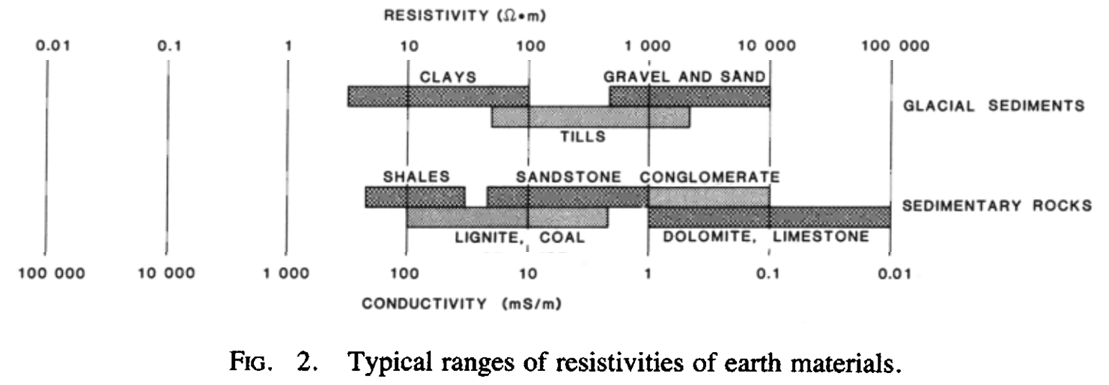

and from Lowrie (2007):

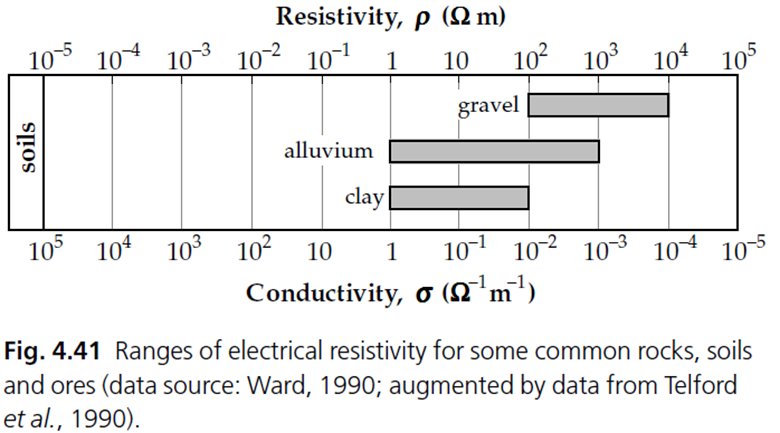

In [ ]:
# Define resistivity values of different materials
AIR_LOGRESISTIVITY = np.log(1e+8)
MUD_LOGRESISTIVITY = np.log(1e+2)
SAND_LOGRESISTIVITY = np.log(1e+3)
GRAVEL_LOGRESISTIVITY = np.log(1e+4)

### Assign materials to different blocks
Attempt to replicate this:

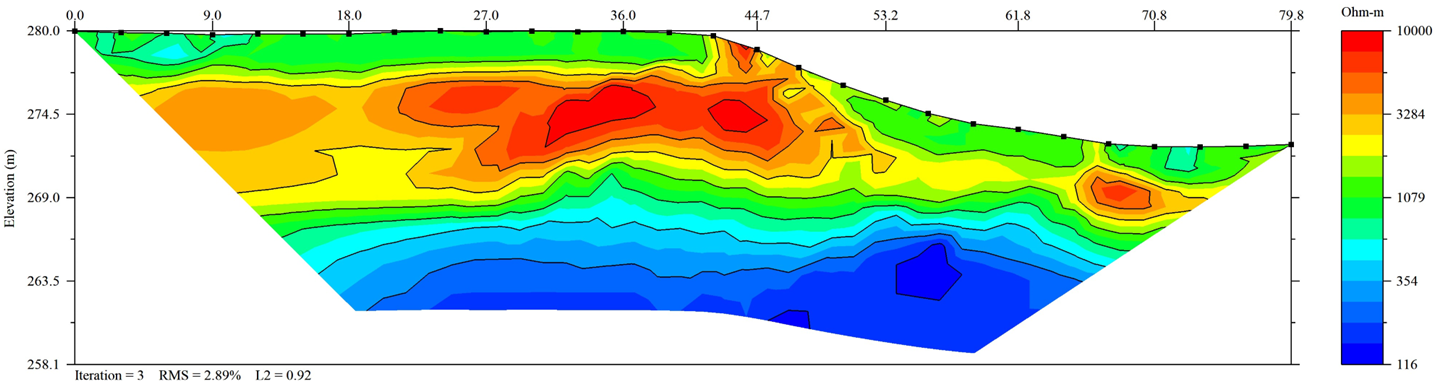

In [ ]:
# number of active cells
number_of_active_cells = np.sum(active_cells)

# UNFAULTED MODEL
# Define background resistivity model as sand.
logresistivity_model_unfaulted = SAND_LOGRESISTIVITY *np.ones(number_of_active_cells)
starting_logresistivity_model = SAND_LOGRESISTIVITY *np.ones(number_of_active_cells)

# Add units of different resistivities
ind_gravel = model_builder.get_indices_block(np.r_[-40,271],np.r_[48,276.5],mesh.cell_centers[active_cells, :])
logresistivity_model_unfaulted[ind_gravel] = GRAVEL_LOGRESISTIVITY

ind_gravel2 = model_builder.get_indices_block(np.r_[65,267],np.r_[120,271],mesh.cell_centers[active_cells, :])
logresistivity_model_unfaulted[ind_gravel2] = GRAVEL_LOGRESISTIVITY

ind_mud = model_builder.get_indices_block(np.r_[-40,258],np.r_[120,266],mesh.cell_centers[active_cells,:])
logresistivity_model_unfaulted[ind_mud] = MUD_LOGRESISTIVITY

### Create Map objects
One for the inversion (i.e., resistivity_map) where the inactive cells are given the res. value of air to keep the inversion stable.

One for figures (i.e., plotting_map) where the inactive cells are given nan values, so that they simply aren't plotted.

In [ ]:
# Resistivity map. Model parameters are log-resistivities for all active cells.
# Assign value of air to inactive cells
logresistivity_map = maps.InjectActiveCells(mesh=mesh,
                                            active_cells=active_cells,
                                            value_inactive=AIR_LOGRESISTIVITY
                                            ) * maps.ExpMap(nP=number_of_active_cells)

# Generate a mapping to ignore inactive cells in plot. Whenever you want to plot the model, you need to multiply
# the resistivity values by this plotting map
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

### Plot the models

In [ ]:
# Hypothetical "unfaulted" model
plot_model_on_survey_and_mesh(mesh=mesh,logresistivity_model=logresistivity_model_unfaulted,
                              plotting_map=plotting_map, survey=survey, title='Unfaulted model', buffer=5)

## Create Simulation object from the Mesh, the Survey, and the resistivity Map

In [ ]:
# Define the DC simulation given the survey setup, the mesh, and the active parts of the mesh
simulation_logresistivity = dc.simulation_2d.Simulation2DNodal(
    mesh=mesh, survey=survey, rhoMap=logresistivity_map
)

# Check simulation
attributes = vars(simulation_logresistivity)
for att, value in attributes.items():
    print(f"{att}: {value}")

## Predict the DC resistivity data from the Simulation and the hypothetical model

In [ ]:
# Simulate the data from the model
data_predicted_normalized_volts_unfaulted = simulation_logresistivity.dpred(logresistivity_model_unfaulted)
# The dpred is always in measured normalized voltages (voltage divided by current, volts/amps, V/A; i.e., resistance).

### Plot the predicted data in a pseudosection

In [ ]:
plot_normalized_volts_and_apparent_resistivity(data=data_predicted_normalized_volts_unfaulted,
                                               survey=survey, title="Unfaulted Model")

## Create Data objects

In [ ]:
# Data from unfaulted model
data_noisy_unfaulted, uncertainties = create_data_object(data_values=data_predicted_normalized_volts_unfaulted, survey=survey,
                                          add_noise=True, export=True, filename='data_noisy_unfaulted_quarterspacingmesh')

In [ ]:
# Field data
field_data, errors = create_data_object(data_values=field_VI.to_numpy(), survey=survey, add_noise=False,
                                        uncertainties=field_error.to_numpy(),
                                        export=True, filename='field_data')

# DC Resistivity 2.5D least-squares inversion 

## Import packages

In [ ]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tarfile

from discretize import TreeMesh
from discretize.utils import mkvc, active_from_xyz

from simpeg.utils import model_builder
from simpeg import (
    maps,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
)
from simpeg.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc

mpl.rcParams.update({"font.size": 16})
# sphinx_gallery_thumbnail_number = 4

## Define the DC Inverse Problem
The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem

In [ ]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(data=data_noisy_unfaulted, simulation=simulation_logresistivity)

# Define the regularization (model objective function)
referencemod = starting_logresistivity_model
reg = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_cells,
    reference_model=referencemod
)

reg.reference_model_in_smooth = True  # Reference model in smoothness term

# Define how the optimization problem is solved. Here we will use an
# Inexact Gauss Newton approach.
opt = optimization.InexactGaussNewton(maxIter=40)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

## Define DC Inversion Directives

Here we define any directives that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.

In [ ]:
# Apply and update sensitivity weighting as the model updates
update_sensitivity_weighting = directives.UpdateSensitivityWeights()

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off parameter value.
beta_schedule = directives.BetaSchedule(coolingFactor=3, coolingRate=3)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=True)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Update preconditioner
update_jacobi = directives.UpdatePreconditioner()

directives_list = [
    update_sensitivity_weighting,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
    update_jacobi,
]

## Create and run the DC Inversion

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.

In [ ]:
# Here we combine the inverse problem and the set of directives
dc_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
startingmodel= starting_logresistivity_model
recovered_resistivity_model = dc_inversion.run(startingmodel)

### Export recovered model
So that we don't have to run the inversion each time.

In [ ]:
save_model_to_txt(model=recovered_resistivity_model, model_filename='recovered_model_unfaulted_quarterspacingmesh')

### Import model from .txt file

In [ ]:
recovered_resistivity_model_unfaulted = load_model_from_txt('recovered_model_unfaulted_quarterspacingmesh.txt')

### Plot recovered model

In [ ]:
plot_initial_and_recovered_models(mesh=mesh, logresmodel_initial=logresistivity_model_unfaulted,
                                  logresmodel_recovered=recovered_resistivity_model_unfaulted, plotting_map=plotting_map,
                                  survey=survey, title='Unfaulted Model', model_min=1e+2, model_max=1e+4)

# Now for the faulted model
### Assign materials to different blocks

In [ ]:
# FAULTED MODEL (fault at x = 42, right side moves down by 2m)
logresistivity_model_faulted = SAND_LOGRESISTIVITY *np.ones(number_of_active_cells)

ind_gravel1_faulted_left = model_builder.get_indices_block(np.r_[-40,271],np.r_[42,276.5],mesh.cell_centers[active_cells, :])
ind_gravel1_faulted_right = model_builder.get_indices_block(np.r_[42,269],np.r_[48,274.5],mesh.cell_centers[active_cells, :])
ind_gravel2_faulted = model_builder.get_indices_block(np.r_[65,265],np.r_[120,269],mesh.cell_centers[active_cells, :])
ind_mud_faulted_left = model_builder.get_indices_block(np.r_[-40,258],np.r_[42,266],mesh.cell_centers[active_cells,:])
ind_mud_faulted_right = model_builder.get_indices_block(np.r_[42,256],np.r_[120,264],mesh.cell_centers[active_cells,:])

logresistivity_model_faulted[ind_gravel1_faulted_left] = GRAVEL_LOGRESISTIVITY
logresistivity_model_faulted[ind_gravel1_faulted_right] = GRAVEL_LOGRESISTIVITY
logresistivity_model_faulted[ind_gravel2_faulted] = GRAVEL_LOGRESISTIVITY
logresistivity_model_faulted[ind_mud_faulted_left] = MUD_LOGRESISTIVITY
logresistivity_model_faulted[ind_mud_faulted_right] = MUD_LOGRESISTIVITY

### Plot the faulted model

In [ ]:
# Hypothetical "faulted model"
plot_model_on_survey_and_mesh(mesh=mesh, logresistivity_model=logresistivity_model_faulted,
                              plotting_map=plotting_map, survey=survey, title='Faulted model')

### Simulate the faulted data

In [ ]:
data_predicted_normalized_volts_faulted = simulation_logresistivity.dpred(logresistivity_model_faulted)

### Plot the simulated data in a pseudo-section

In [ ]:
plot_normalized_volts_and_apparent_resistivity(data=data_predicted_normalized_volts_unfaulted,
                                               survey=survey, title="Faulted Model")

### Create Data object for faulted model

In [ ]:
data_noisy_faulted, _ = create_data_object(data_values=data_predicted_normalized_volts_faulted, survey=survey,
                                        add_noise=True, export=True, filename='data_noisy_faulted_quarterspacingmesh')

### Update the data_misfit of the inverse_problem

In [ ]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis_faulted = data_misfit.L2DataMisfit(data=data_noisy_faulted, simulation=simulation_logresistivity)

# Define the regularization (model objective function)
referencemod = starting_logresistivity_model
reg = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_cells,
    reference_model=referencemod
)

reg.reference_model_in_smooth = True  # Reference model in smoothness term

# Define how the optimization problem is solved. Here we will use an
# Inexact Gauss Newton approach.
opt = optimization.InexactGaussNewton(maxIter=40)

# Here we define the inverse problem that is to be solved
inv_prob_faulted = inverse_problem.BaseInvProblem(dmis_faulted, reg, opt)

### Using the same directives, run the inverse problem

In [ ]:
# Apply and update sensitivity weighting as the model updates
update_sensitivity_weighting = directives.UpdateSensitivityWeights()

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off parameter value.
beta_schedule = directives.BetaSchedule(coolingFactor=3, coolingRate=3)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=True)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Update preconditioner
update_jacobi = directives.UpdatePreconditioner()

directives_list = [
    update_sensitivity_weighting,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
    update_jacobi,
]

In [ ]:
# Here we combine the inverse problem and the set of directives
dc_inversion_faulted = inversion.BaseInversion(inv_prob_faulted, directiveList=directives_list)

# Run inversion
startingmodel= starting_logresistivity_model
recovered_resistivity_model_faulted = dc_inversion_faulted.run(startingmodel)

### Save and then import the recovered model

In [ ]:
save_model_to_txt(model=recovered_resistivity_model_faulted, model_filename='recovered_model_faulted_quarterspacingmesh')

In [ ]:
recovered_resistivity_model_faulted = load_model_from_txt(file_to_import='recovered_model_faulted_quarterspacingmesh.txt')

### Plot recovered model

In [ ]:
plot_initial_and_recovered_models(mesh=mesh, logresmodel_initial=logresistivity_model_faulted,
                                  logresmodel_recovered=recovered_resistivity_model_faulted, plotting_map=plotting_map,
                                  survey=survey, title='Faulted Model', model_min=1e+2, model_max=1e+4)

# And now for the field data
### Plot field data

In [ ]:
plot_normalized_volts_and_apparent_resistivity(data=field_data.dobs, survey=survey, mesh=mesh, title='Field Data')

### Define the inverse problem for the field data

In [ ]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis_field = data_misfit.L2DataMisfit(data=field_data, simulation=simulation_logresistivity)

# Define the regularization (model objective function)
# Set referencemod to the mean apparent log-resistivity of the field data. 
referencemod = np.ceil(np.mean(np.log(apparent_resistivity_from_voltage(survey,field_VI))) * np.ones(number_of_active_cells))
reg = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_cells,
    reference_model=referencemod
)

reg.reference_model_in_smooth = True  # Reference model in smoothness term

# Define how the optimization problem is solved. Here we will use an
# Inexact Gauss Newton approach.
opt = optimization.InexactGaussNewton(maxIter=40)

# Here we define the inverse problem that is to be solved
inv_prob_field = inverse_problem.BaseInvProblem(dmis_field, reg, opt)

### Using the same directives, run the inverse problem for the field data

In [ ]:
# Apply and update sensitivity weighting as the model updates
update_sensitivity_weighting = directives.UpdateSensitivityWeights()

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off parameter value.
beta_schedule = directives.BetaSchedule(coolingFactor=3, coolingRate=3)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=True)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Update preconditioner
update_jacobi = directives.UpdatePreconditioner()

directives_list = [
    update_sensitivity_weighting,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
    update_jacobi,
]

In [ ]:
# Here we combine the inverse problem and the set of directives
dc_inversion_field = inversion.BaseInversion(inv_prob_field, directiveList=directives_list)

# Run inversion
startingmodel= referencemod
recovered_resistivity_model_field = dc_inversion_field.run(startingmodel)

### Save and then import the model recovered from field data

In [ ]:
save_model_to_txt(model=recovered_resistivity_model_field, model_filename='recovered_model_field_quarterspacingmesh')

In [ ]:
recovered_resistivity_model_field = load_model_from_txt(file_to_import='recovered_model_field_quarterspacingmesh.txt')

### Plot the model recovered from the field

In [ ]:
plot_model_on_survey_and_mesh(mesh=mesh, logresistivity_model=recovered_resistivity_model_field, plotting_map=plotting_map,
                              survey=survey, title="Model recovered from Field Data", model_min=1e+2, model_max=1e+4,buffer=0)

In [ ]:
dpred = inv_prob_field.dpred
dobs = field_data.dobs
std = field_data.standard_deviation

In [ ]:
residual = dpred - dobs
relative_misfits = (residual/np.abs(dobs)) # Probably better to look at
# misfits = ((1/std)* residual)**2
noisy_data_points = np.abs(relative_misfits) > 0.95
noisy_data_points

In [ ]:
rms = np.sqrt(np.sum(relative_misfits**2)/relative_misfits.size)*100
rms

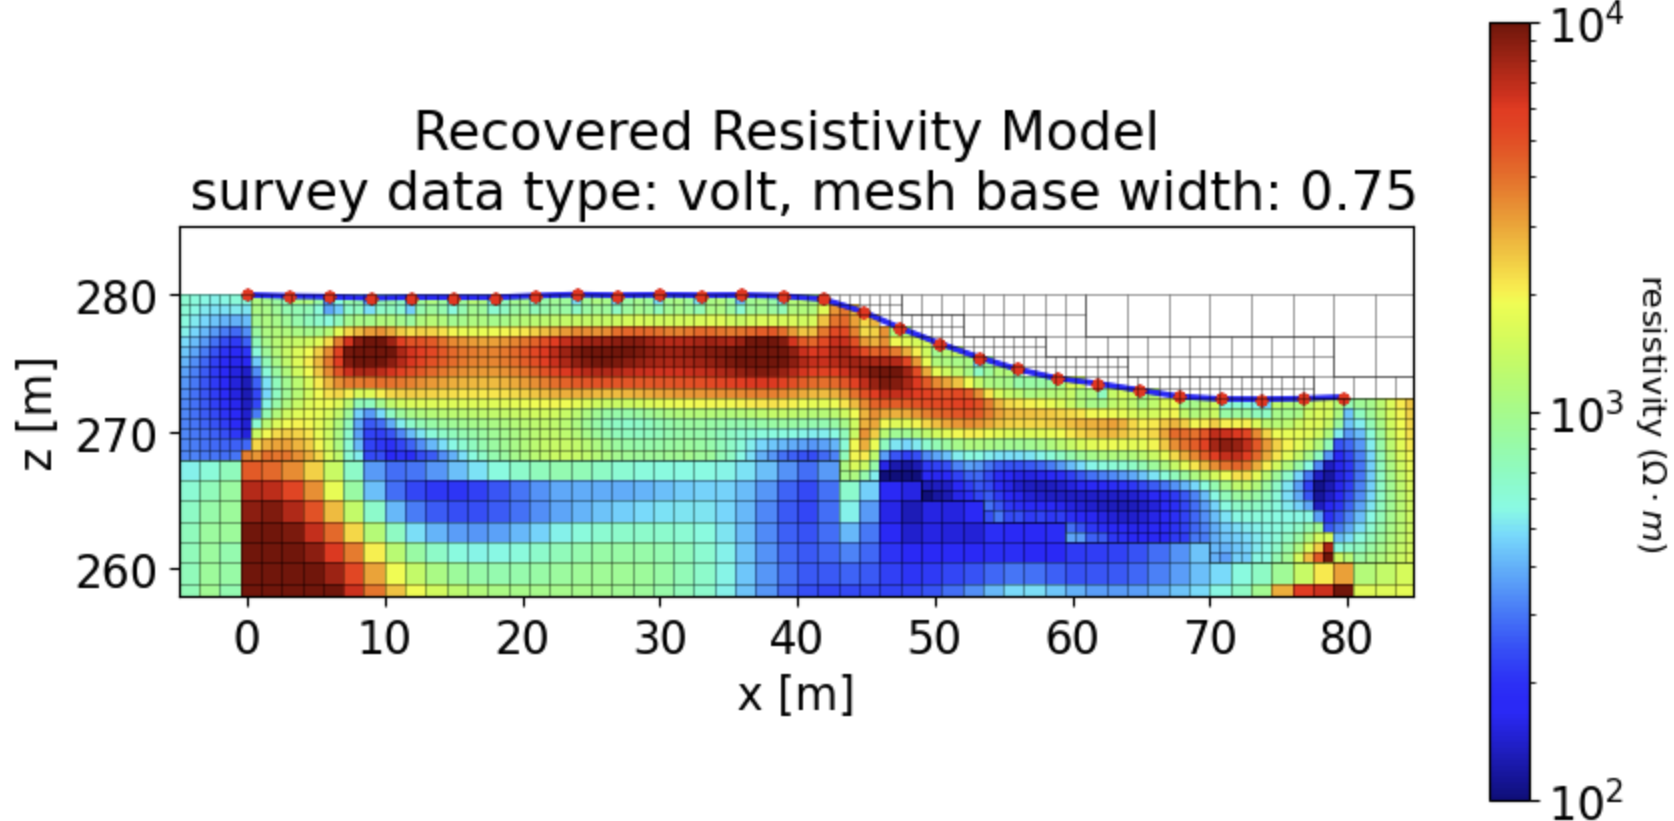
Field data:

With noise

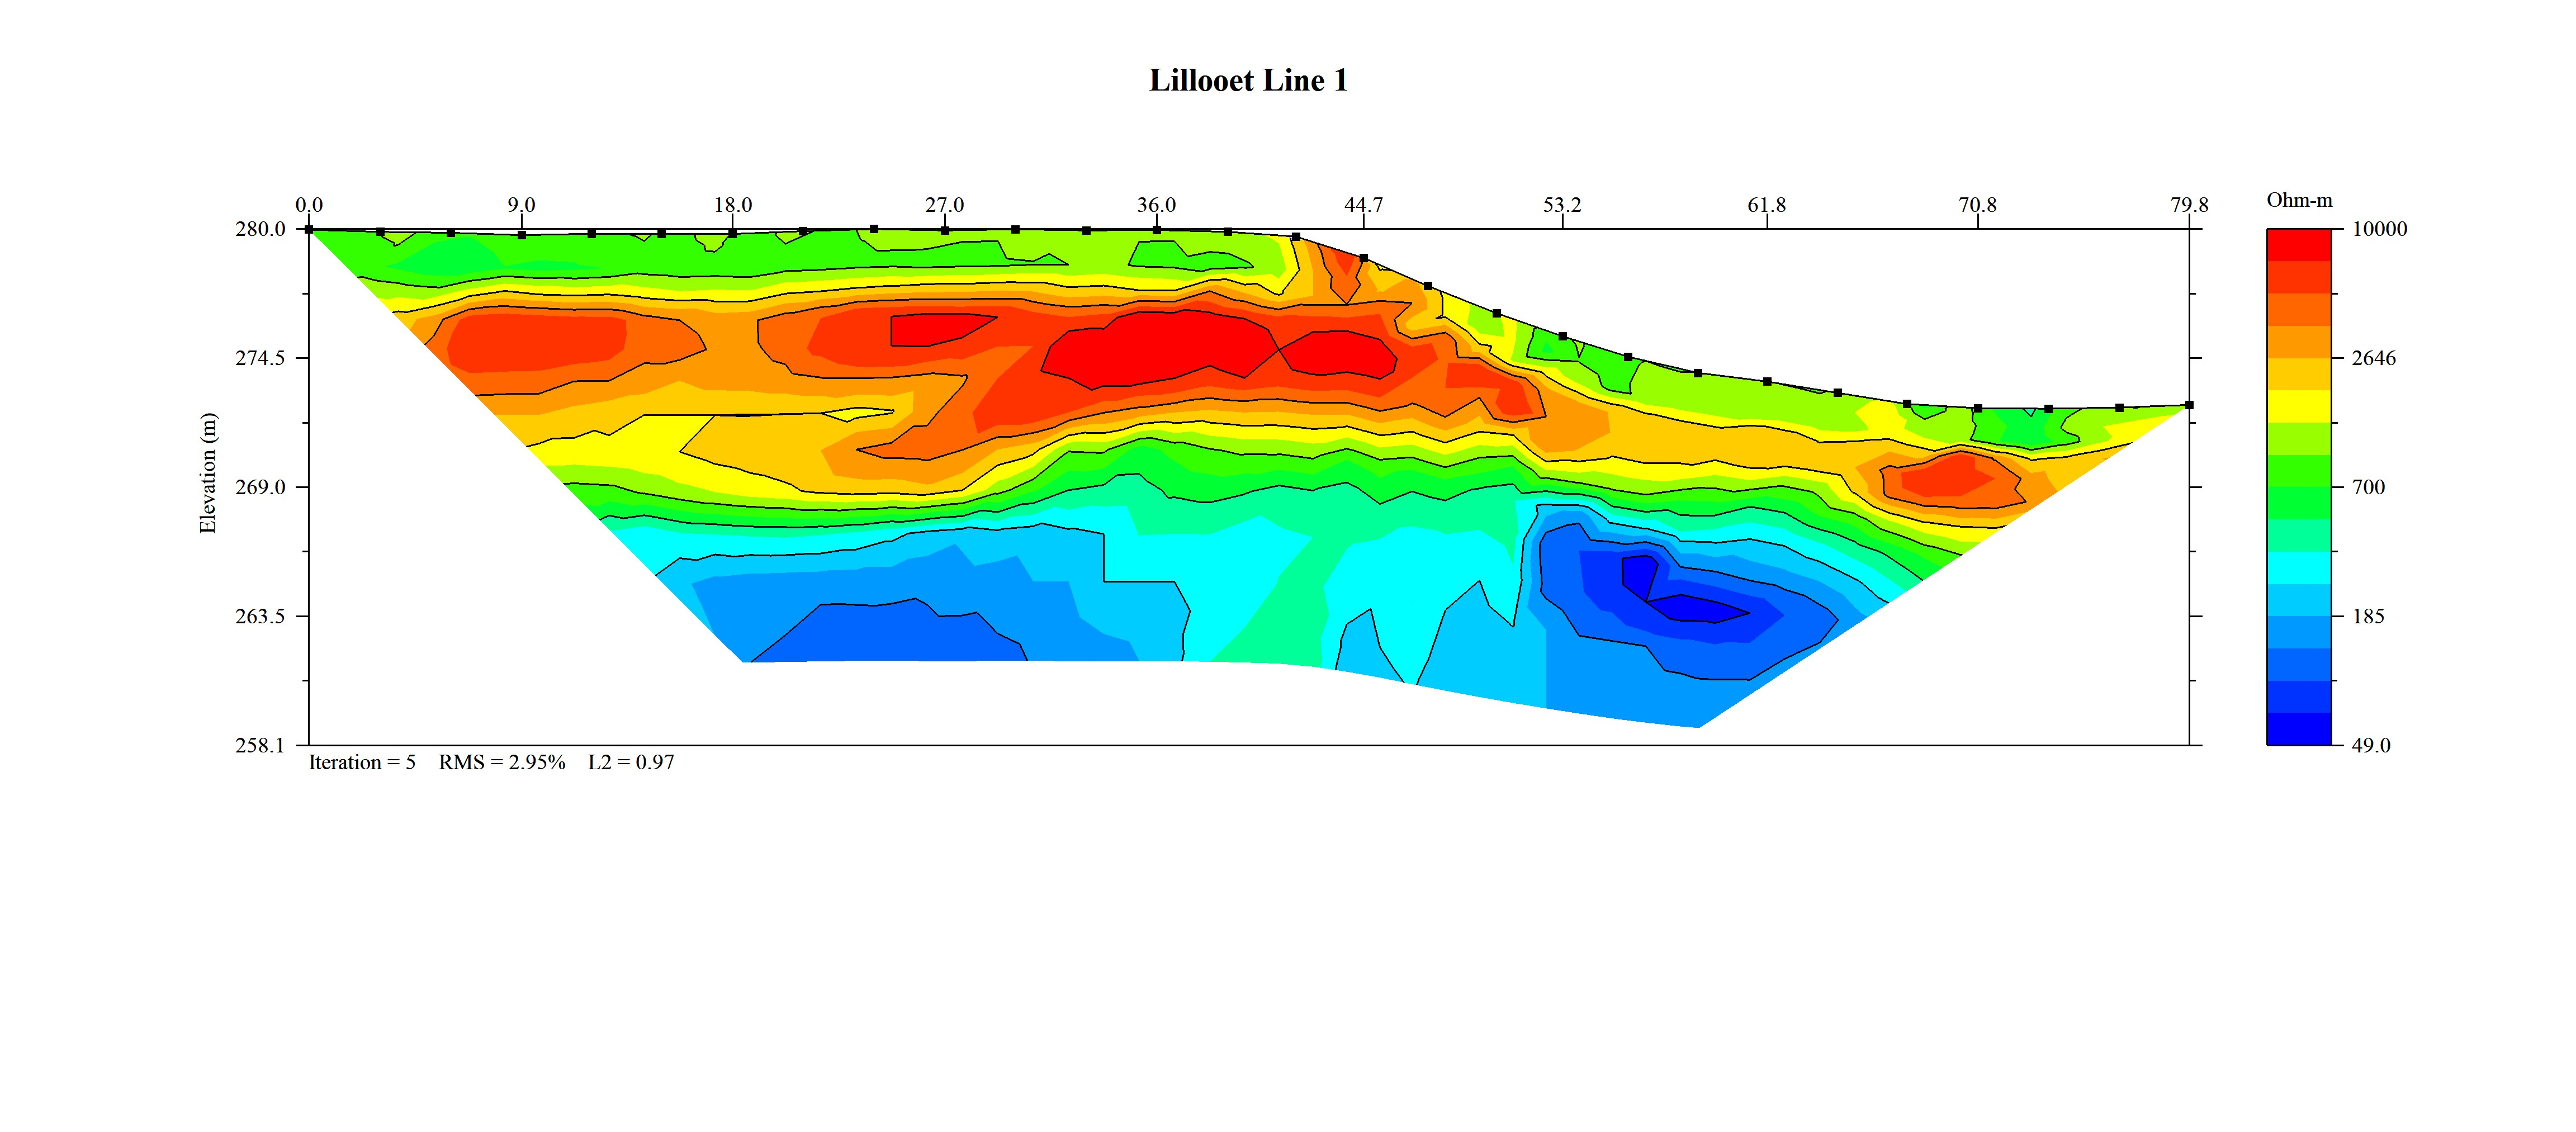

Noisy data points filtered out

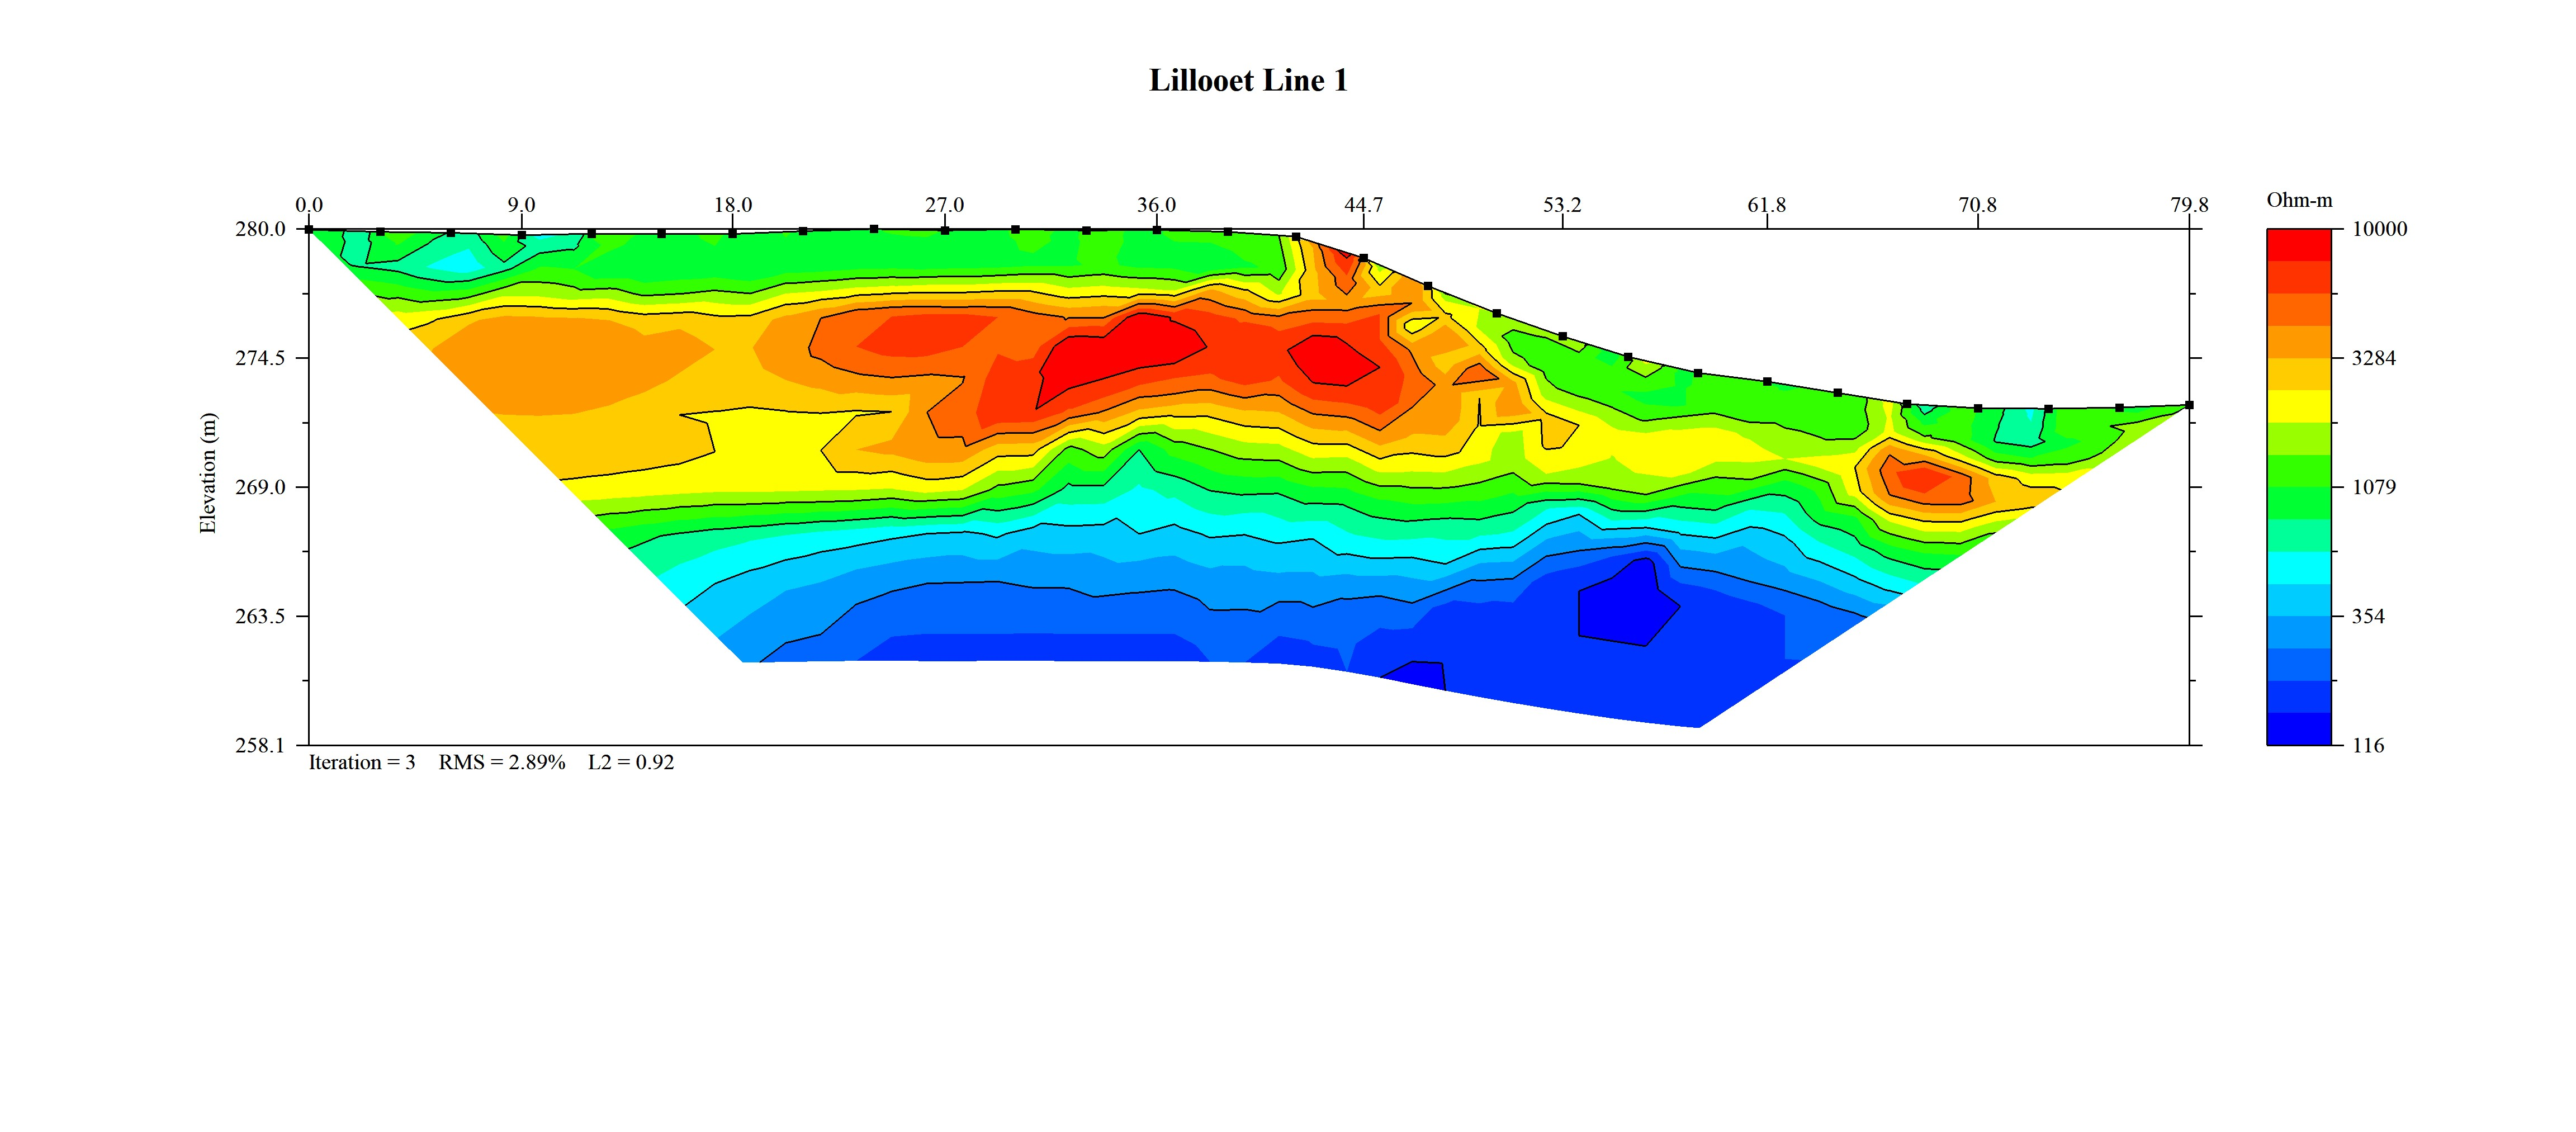

## Calculate RMS error
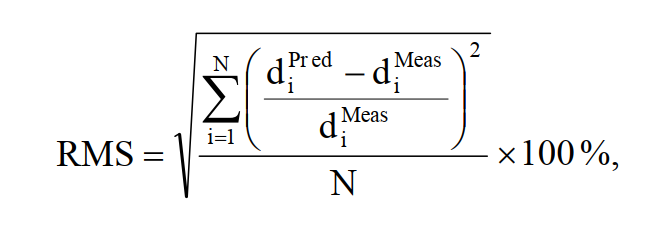

## L2-Norm and Normalized L2-Norm
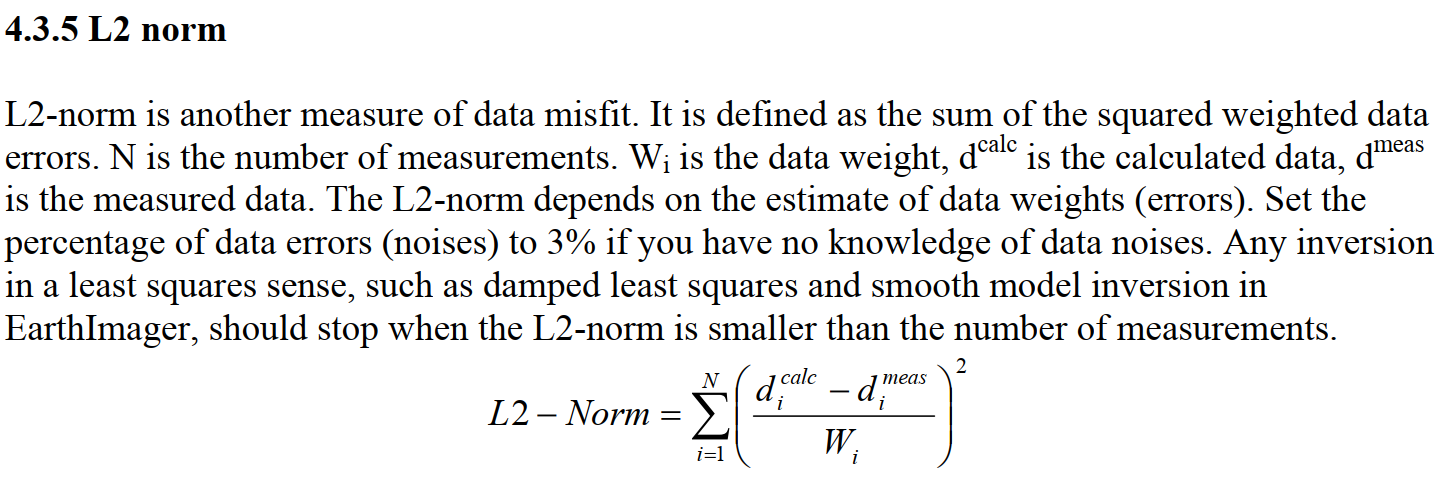
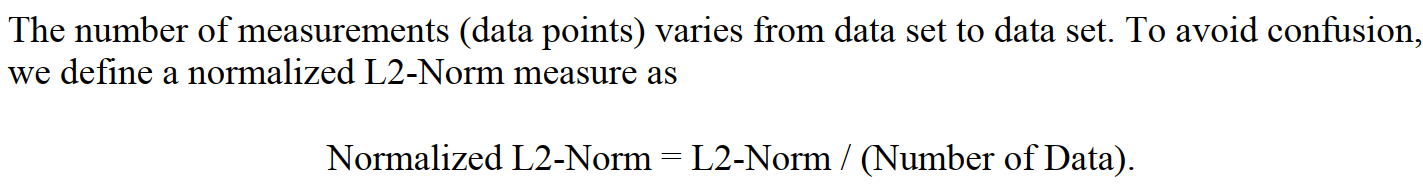

In [ ]:
# dpred_recovered = simulation_logresistivity.dpred(recovered_resistivity_model)
# apparent_resistivities_recovered = apparent_resistivity_from_voltage(survey, dpred_recovered)